In [4]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
import os
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import cv2
%matplotlib inline
sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')

### Load resized images as numpy rgb vectors

In [68]:
def load_image_data(folder_benign='../data/resized/benign', folder_malignant='../data/resized/malignant'):
    ims_benign = np.array([cv2.imread(os.path.join(folder_benign, filename)) for filename in os.listdir(folder_benign)])
    ims_malignant = np.array([cv2.imread(os.path.join(folder_malignant, filename)) for filename in os.listdir(folder_malignant)])
    print(f"Benign images vector shape: {ims_benign.shape}")
    print(f"Malignant images vector shape: {ims_malignant.shape}")
    return ims_benign, ims_malignant

### Loading the new features extracted as the per the research done for non-pixel based features

In [61]:
def load_extracted_features(benign_file='../data/benign_features.txt', malignant_file='../data/malignant_features.txt'):
    benign_df = pd.read_csv(benign_file, sep='\t', header=None)
    malignant_df = pd.read_csv(malignant_file, sep='\t', header=None)
    X_benign_new = benign_df.reset_index().values[:, 1:]
    X_malinant_new = malignant_df.reset_index().values[:, 1:]
    return X_benign_new, X_malinant_new

In [62]:
def flatten_image_vectors_and_generate_labels(ims_benign, ims_malignant):
    X_benign = ims_benign.flatten().reshape(ims_benign.shape[0], ims_benign.shape[1] * ims_benign.shape[2] * ims_benign.shape[3])
    X_malinant = ims_malignant.flatten().reshape(ims_malignant.shape[0], ims_malignant.shape[1] * ims_malignant.shape[2] * ims_malignant.shape[3])
    return X_benign, X_malinant

In [63]:
def get_test_train_data(X_benign, X_malinant, seed, scaled=True):
    X_train_benign, X_test_benign, Y_train_benign, Y_test_benign = train_test_split(X_benign, np.zeros(X_benign.shape[0]), test_size=0.1, random_state=seed)
    X_train_malinant, X_test_malinant, Y_train_malinant, Y_test_malinant = train_test_split(X_malinant, np.ones(X_malinant.shape[0]), test_size=0.1, random_state=seed)
    X_train = np.concatenate((X_train_benign, X_train_malinant), axis=0)
    Y_train = np.concatenate((Y_train_benign, Y_train_malinant), axis=0)
    X_test = np.concatenate((X_test_benign, X_test_malinant), axis=0)
    Y_test = np.concatenate((Y_test_benign, Y_test_malinant), axis=0)
    if scaled:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, Y_train, Y_test
    return (X_train, X_test, Y_train, Y_test)

In [64]:
def runPCA(X_benign, X_malinant):
    print(X_benign.shape)
    X = np.concatenate((X_benign, X_malinant), axis=0)  
    pca = PCA(0.995)
    X_PCA = pca.fit_transform(X)
    return X_PCA

#### Preparing data

In [70]:
# Loading images
seed=42
ims_benign, ims_malignant = load_image_data('../data/resized_600_450/benign', '../data/resized_600_450/malignant/')
X_benign,X_malinant = flatten_image_vectors_and_generate_labels(ims_benign=ims_benign, ims_malignant=ims_malignant)
X_train_full, X_test_full, Y_train_full, Y_test_full = get_test_train_data(X_benign=X_benign, X_malinant=X_malinant, seed=seed)

# Load other features
X_benign_new, X_malinant_new = load_extracted_features()
X_train_new, X_test_new, Y_train_new, Y_test_new = get_test_train_data(X_benign_new, X_malinant_new, seed)

# Combined features
X_train_full_all, X_test_full_all, Y_train_full_all, Y_test_full_all = get_test_train_data(
    np.concatenate((X_benign_new, X_benign), axis=1), np.concatenate((X_malinant_new, X_malinant), axis=1), seed)

X = runPCA(X_benign, X_malinant)
Y = np.concatenate((np.zeros(X_benign.shape[0]), np.ones(X_malinant.shape[0])))
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X, Y, test_size=0.1, random_state=42)

X_new = np.concatenate((X_benign_new, X_malinant_new), axis=0)
X_train_pca_all, X_test_pca_all, Y_train_pca_all, Y_test_pca_all = \
    train_test_split(np.concatenate((X_new, X), axis=1), Y, test_size=0.1, random_state=42)

all_data_set = {
    'full' : (X_train_full, X_test_full, Y_train_full, Y_test_full),
    'pca': (X_train_pca, X_test_pca, Y_train_pca, Y_test_pca)
}

Benign images vector shape: (150, 450, 600, 3)
Malignant images vector shape: (150, 450, 600, 3)
(150, 810000)


In [76]:
seed=42
ims_benign, ims_malignant = load_image_data('../data/resized_600_450/benign', '../data/resized_600_450/malignant/')
X_benign,X_malinant = flatten_image_vectors_and_generate_labels(ims_benign=ims_benign, ims_malignant=ims_malignant)
X_train_full, X_test_full, Y_train_full, Y_test_full = get_test_train_data(X_benign=X_benign, X_malinant=X_malinant, seed=seed)
scaler = StandardScaler().fit(X_train_full)
X_train = scaler.transform(X_train_full)
X_test = scaler.transform(X_test_full)
pca = PCA(.99)
pca.fit(X_train)

X_train_p = pca.transform(X_train)
X_test_p = pca.transform(X_test)




Benign images vector shape: (150, 450, 600, 3)
Malignant images vector shape: (150, 450, 600, 3)


In [77]:
X_train_p.shape

(270, 174)

In [81]:
clf = svm.SVC(random_state=42)
clf.fit(X_train_p, Y_train_full)
pred = clf.predict(X_test_p)
accuracy_score(Y_test_full, pred)

0.6666666666666666

In [75]:
scaler = StandardScaler().fit(X_train_pca)
X_train_pca_s = scaler.transform(X_train_pca)
X_test_pca_s = scaler.transform(X_test_pca)
clf = svm.SVC(random_state=42)
clf.fit(X_train_pca_s, Y_train_pca)
pred = clf.predict(X_test_pca_s)
accuracy_score(Y_test_pca, pred)


0.3333333333333333

In [54]:
seed = 42
num_trees=150
models = {
     'SVM' : svm.SVC(C=10, random_state=42, gamma='scale'),
     'LDA' : LinearDiscriminantAnalysis(),
     'XGBoost' : xgb.XGBClassifier(),
     'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed),
     'LR':LogisticRegression(solver='lbfgs', max_iter=1000)
 }

(270,)
Model:SVM --> Mean:[0.674074074074074] , STD:[0.07908946853356527]


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

Model:LDA --> Mean:[0.5592592592592592] , STD:[0.1128870418824309]
Model:XGBoost --> Mean:[0.5814814814814815] , STD:[0.08453860896676539]
Model:RF --> Mean:[0.5444444444444444] , STD:[0.07416660886852144]
Model:LR --> Mean:[0.5962962962962963] , STD:[0.08020891788039893]


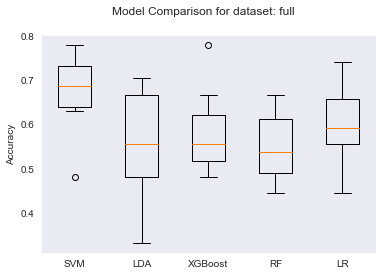

(270,)
Model:SVM --> Mean:[0.7370370370370372] , STD:[0.07490277191169141]
Model:LDA --> Mean:[0.6148148148148149] , STD:[0.09543776834611205]
Model:XGBoost --> Mean:[0.6333333333333333] , STD:[0.06296296296296297]
Model:RF --> Mean:[0.6666666666666667] , STD:[0.07768954430890011]
Model:LR --> Mean:[0.6444444444444445] , STD:[0.09102374612921858]


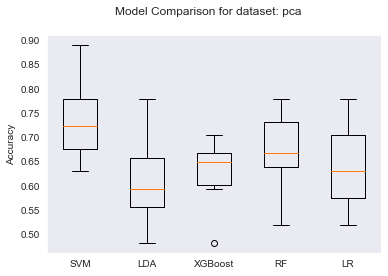

In [58]:
for dataset, data in all_data_set.items():
    results = []
    names = []
    X_train, X_test, Y_train, Y_test = data
    print(Y_train.shape)
    for name, model in models.items():
        cv_results = cross_val_score(model, X_train, Y_train, cv=KFold(n_splits=10), scoring="accuracy")
        print(f"Model:{name} --> Mean:[{cv_results.mean()}] , STD:[{cv_results.std()}]")
        names.append(name)
        results.append(cv_results)
    fig = plt.figure()
    fig.suptitle(f'Model Comparison for dataset: {dataset}')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.ylabel("Accuracy")
    plt.show()

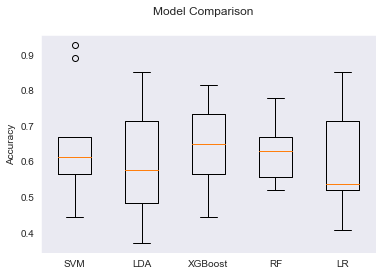

0.8333333333333334

### Support Vector Machine models -- GridSearch

In [83]:
from sklearn.multiclass import OneVsRestClassifier
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv=KFold(n_splits=10), n_jobs=5)   
# fitting the model for grid search
grid.fit(X_train_p, Y_train_full)
# clf = svm.SVC(random_state=42, probability=True)
# clf.fit(X_train_full, Y_train_full)
# pred = clf.predict(X_test_pca_all)
# print(f"Default SVM Accuracy (on only pixel): {accuracy_score(Y_test_pca_all, pred)}")

# clf = svm.SVC(C=10, random_state=seed)
# clf.fit(X_train_new, Y_train_new)
# pred = clf.predict(X_test_new)
# print(f"Default SVM Accuracy (on only new features): {accuracy_score(Y_test_new, pred)}")

# clf = svm.SVC(C=10,random_state=seed)
# clf.fit(X_train_full_all, Y_train_full_all)
# pred = clf.predict(X_test_all)
# print(f"Default SVM Accuracy (on combined features): {accuracy_score(Y_test_all, pred)}")

# clf = svm.SVC(C=10,random_state=seed)
# clf.fit(X_tra, Y_train_all)
# pred = clf.predict(X_test_all)
# print(f"Default SVM Accuracy (PCA features): {accuracy_score(Y_test_all, pred)}")

# clf = svm.SVC(C=10,random_state=seed)
# clf.fit(X_train_all, Y_train_all)
# pred = clf.predict(X_test_all)
# print(f"Default SVM Accuracy (PCA + new_features): {accuracy_score(Y_test_all, pred)}")


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    1.2s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [56]:
Cs = param_grid['C']
Gammas = param_grid['gamma']
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))
for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [85]:
pred = grid.best_estimator_.predict(X_test_p)
accuracy_score(Y_test_full, pred)

0.5

In [42]:
fpr, tpr, _ = roc_curve(Y_test_new, clf.decision_function(X_test_new))
roc_auc = auc(fpr, tpr)

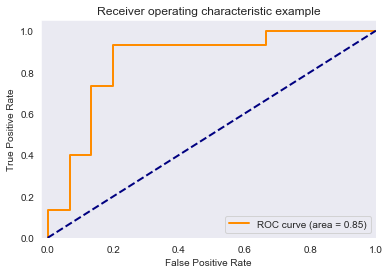

In [43]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### XGBoost

In [11]:

clf =  xgb.XGBClassifier()
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
print(f"Default XGBoost Accuracy (on only pixel): {accuracy_score(Y_test, pred)}")

clf = xgb.XGBClassifier()
clf.fit(X_train_new, Y_train_new)
pred = clf.predict(X_test_new)
print(f"Default XGBoost Accuracy (on only new features): {accuracy_score(Y_test_new, pred)}")

clf = xgb.XGBClassifier()
clf.fit(X_train_all, Y_train_all)
pred = clf.predict(X_test_all)
print(f"Default XGBoost Accuracy (on combined features): {accuracy_score(Y_test_all, pred)}")

Default XGBoost Accuracy (on only pixel): 0.7333333333333333
Default XGBoost Accuracy (on only new features): 0.7333333333333333
Default XGBoost Accuracy (on combined features): 0.8


In [ ]:
clf =  xgb.XGBClassifier()
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
print(f"Default XGBoost Accuracy (on only pixel): {accuracy_score(Y_test, pred)}")

clf = xgb.XGBClassifier()
clf.fit(X_train_new, Y_train_new)
pred = clf.predict(X_test_new)
print(f"Default XGBoost Accuracy (on only new features): {accuracy_score(Y_test_new, pred)}")

clf = xgb.XGBClassifier()
clf.fit(X_train_all, Y_train_all)
pred = clf.predict(X_test_all)
print(f"Default XGBoost Accuracy (on combined features): {accuracy_score(Y_test_all, pred)}")

In [ ]:
models = {
    'SVM' : svm.SVC(random_state=seed)
    'LDA' : LinearDiscriminantAnalysis(random_state=seed)
}

#### SVM Hyperparamtuning

In [66]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv=5, n_jobs=5)   
# fitting the model for grid search

grid.fit(X_train_new, Y_train_new)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [67]:
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
pred = grid.best_estimator_.predict(X_train_new)
accuracy_score(pred, Y_train_new)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


0.725925925925926

#### Using new feature alongwith 

In [140]:
benign_df = pd.read_csv('../data/benign_features.txt', sep='\t', header=None)
malignant_df = pd.read_csv('../data/malignant_features.txt', sep='\t', header=None)

X_benign_new = benign_df.reset_index().values[:, 1:]
X_malinant_new = malignant_df.reset_index().values[:, 1:]
X_benign_all = np.concatenate((X_benign_new, X_benign), axis=1)
X_malinant_all = np.concatenate((X_malinant_new, X_malinant), axis=1)

In [141]:
X_train, X_test, Y_train, Y_test = get_test_train_data(X_benign=X_benign_all, X_malinant=X_malinant_all, seed=42)

print(Y_test.shape)
clf = svm.SVC()
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, pred)}")

(30,)
Accuracy: 0.7666666666666667


TypeError: list indices must be integers or slices, not str

#### Catboost

In [32]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(X_train_scaled, Y_train, None)
predictions = model.predict(X_test_scaled)
accuracy_score(Y_test, predictions)

Learning rate set to 0.011566
0:	learn: 0.6893397	total: 8.54s	remaining: 2h 22m 10s
1:	learn: 0.6847578	total: 11.4s	remaining: 1h 35m 3s
2:	learn: 0.6802358	total: 13.5s	remaining: 1h 14m 43s
3:	learn: 0.6753423	total: 15.4s	remaining: 1h 3m 53s
4:	learn: 0.6717818	total: 17.5s	remaining: 57m 56s
5:	learn: 0.6677444	total: 20.2s	remaining: 55m 50s
6:	learn: 0.6642759	total: 22.3s	remaining: 52m 42s
7:	learn: 0.6608265	total: 24.3s	remaining: 50m 7s
8:	learn: 0.6555456	total: 26.2s	remaining: 48m 8s
9:	learn: 0.6519316	total: 28.1s	remaining: 46m 26s
10:	learn: 0.6475387	total: 30.1s	remaining: 45m 9s
11:	learn: 0.6441030	total: 32.5s	remaining: 44m 34s
12:	learn: 0.6410656	total: 35.4s	remaining: 44m 50s
13:	learn: 0.6360882	total: 38.2s	remaining: 44m 51s
14:	learn: 0.6323012	total: 44.4s	remaining: 48m 32s
15:	learn: 0.6289943	total: 51.7s	remaining: 53m
16:	learn: 0.6262359	total: 55.1s	remaining: 53m 3s
17:	learn: 0.6230002	total: 57.3s	remaining: 52m 7s
18:	learn: 0.6195007	tota

152:	learn: 0.3434479	total: 6m 24s	remaining: 35m 27s
153:	learn: 0.3419492	total: 6m 26s	remaining: 35m 21s
154:	learn: 0.3406387	total: 6m 27s	remaining: 35m 15s
155:	learn: 0.3395722	total: 6m 29s	remaining: 35m 9s
156:	learn: 0.3386160	total: 6m 31s	remaining: 35m 3s
157:	learn: 0.3369305	total: 6m 33s	remaining: 34m 58s
158:	learn: 0.3359525	total: 6m 35s	remaining: 34m 52s
159:	learn: 0.3345809	total: 6m 37s	remaining: 34m 47s
160:	learn: 0.3337251	total: 6m 39s	remaining: 34m 42s
161:	learn: 0.3327591	total: 6m 41s	remaining: 34m 37s
162:	learn: 0.3315648	total: 6m 43s	remaining: 34m 32s
163:	learn: 0.3306837	total: 6m 45s	remaining: 34m 26s
164:	learn: 0.3299778	total: 6m 47s	remaining: 34m 21s
165:	learn: 0.3294982	total: 6m 49s	remaining: 34m 16s
166:	learn: 0.3282914	total: 6m 51s	remaining: 34m 10s
167:	learn: 0.3272642	total: 6m 53s	remaining: 34m 5s
168:	learn: 0.3266926	total: 6m 54s	remaining: 34m
169:	learn: 0.3254520	total: 6m 56s	remaining: 33m 55s
170:	learn: 0.324

302:	learn: 0.2117803	total: 11m 15s	remaining: 25m 53s
303:	learn: 0.2110190	total: 11m 17s	remaining: 25m 50s
304:	learn: 0.2104839	total: 11m 19s	remaining: 25m 47s
305:	learn: 0.2099814	total: 11m 21s	remaining: 25m 44s
306:	learn: 0.2093823	total: 11m 22s	remaining: 25m 41s
307:	learn: 0.2089313	total: 11m 24s	remaining: 25m 38s
308:	learn: 0.2084889	total: 11m 26s	remaining: 25m 35s
309:	learn: 0.2078297	total: 11m 28s	remaining: 25m 32s
310:	learn: 0.2075474	total: 11m 30s	remaining: 25m 29s
311:	learn: 0.2069337	total: 11m 32s	remaining: 25m 26s
312:	learn: 0.2059745	total: 11m 33s	remaining: 25m 23s
313:	learn: 0.2053911	total: 11m 35s	remaining: 25m 19s
314:	learn: 0.2047483	total: 11m 37s	remaining: 25m 16s
315:	learn: 0.2038260	total: 11m 39s	remaining: 25m 14s
316:	learn: 0.2032150	total: 11m 41s	remaining: 25m 11s
317:	learn: 0.2028435	total: 11m 43s	remaining: 25m 8s
318:	learn: 0.2022910	total: 11m 45s	remaining: 25m 6s
319:	learn: 0.2018273	total: 11m 47s	remaining: 25

450:	learn: 0.1344519	total: 16m 48s	remaining: 20m 27s
451:	learn: 0.1338805	total: 16m 50s	remaining: 20m 24s
452:	learn: 0.1335263	total: 16m 52s	remaining: 20m 22s
453:	learn: 0.1331175	total: 16m 54s	remaining: 20m 19s
454:	learn: 0.1325661	total: 16m 56s	remaining: 20m 17s
455:	learn: 0.1322318	total: 16m 57s	remaining: 20m 14s
456:	learn: 0.1320252	total: 16m 59s	remaining: 20m 11s
457:	learn: 0.1315566	total: 17m 1s	remaining: 20m 9s
458:	learn: 0.1310219	total: 17m 3s	remaining: 20m 6s
459:	learn: 0.1308216	total: 17m 5s	remaining: 20m 4s
460:	learn: 0.1304027	total: 17m 7s	remaining: 20m 1s
461:	learn: 0.1300530	total: 17m 9s	remaining: 19m 59s
462:	learn: 0.1297540	total: 17m 11s	remaining: 19m 56s
463:	learn: 0.1293376	total: 17m 13s	remaining: 19m 54s
464:	learn: 0.1288181	total: 17m 15s	remaining: 19m 51s
465:	learn: 0.1283754	total: 17m 17s	remaining: 19m 48s
466:	learn: 0.1278932	total: 17m 19s	remaining: 19m 46s
467:	learn: 0.1274224	total: 17m 21s	remaining: 19m 43s
4

598:	learn: 0.0791862	total: 21m 53s	remaining: 14m 39s
599:	learn: 0.0787762	total: 21m 55s	remaining: 14m 37s
600:	learn: 0.0784884	total: 21m 57s	remaining: 14m 34s
601:	learn: 0.0781571	total: 21m 59s	remaining: 14m 32s
602:	learn: 0.0778243	total: 22m 1s	remaining: 14m 30s
603:	learn: 0.0775315	total: 22m 3s	remaining: 14m 27s
604:	learn: 0.0771713	total: 22m 5s	remaining: 14m 25s
605:	learn: 0.0768502	total: 22m 7s	remaining: 14m 23s
606:	learn: 0.0764983	total: 22m 9s	remaining: 14m 20s
607:	learn: 0.0762237	total: 22m 12s	remaining: 14m 18s
608:	learn: 0.0759118	total: 22m 14s	remaining: 14m 16s
609:	learn: 0.0756032	total: 22m 16s	remaining: 14m 14s
610:	learn: 0.0752317	total: 22m 18s	remaining: 14m 12s
611:	learn: 0.0748757	total: 22m 20s	remaining: 14m 9s
612:	learn: 0.0745919	total: 22m 22s	remaining: 14m 7s
613:	learn: 0.0743346	total: 22m 24s	remaining: 14m 5s
614:	learn: 0.0740096	total: 22m 26s	remaining: 14m 2s
615:	learn: 0.0737102	total: 22m 27s	remaining: 14m
616:	

746:	learn: 0.0430138	total: 27m 5s	remaining: 9m 10s
747:	learn: 0.0428641	total: 27m 7s	remaining: 9m 8s
748:	learn: 0.0426734	total: 27m 9s	remaining: 9m 5s
749:	learn: 0.0424741	total: 27m 11s	remaining: 9m 3s
750:	learn: 0.0423469	total: 27m 13s	remaining: 9m 1s
751:	learn: 0.0421979	total: 27m 15s	remaining: 8m 59s
752:	learn: 0.0420567	total: 27m 17s	remaining: 8m 57s
753:	learn: 0.0419051	total: 27m 19s	remaining: 8m 54s
754:	learn: 0.0417550	total: 27m 21s	remaining: 8m 52s
755:	learn: 0.0415770	total: 27m 23s	remaining: 8m 50s
756:	learn: 0.0414450	total: 27m 24s	remaining: 8m 48s
757:	learn: 0.0412619	total: 27m 26s	remaining: 8m 45s
758:	learn: 0.0411258	total: 27m 28s	remaining: 8m 43s
759:	learn: 0.0409552	total: 27m 30s	remaining: 8m 41s
760:	learn: 0.0407639	total: 27m 32s	remaining: 8m 38s
761:	learn: 0.0406112	total: 27m 34s	remaining: 8m 36s
762:	learn: 0.0404311	total: 27m 36s	remaining: 8m 34s
763:	learn: 0.0403222	total: 27m 38s	remaining: 8m 32s
764:	learn: 0.040

897:	learn: 0.0253791	total: 32m 11s	remaining: 3m 39s
898:	learn: 0.0253121	total: 32m 13s	remaining: 3m 37s
899:	learn: 0.0252362	total: 32m 15s	remaining: 3m 35s
900:	learn: 0.0251840	total: 32m 17s	remaining: 3m 32s
901:	learn: 0.0251147	total: 32m 19s	remaining: 3m 30s
902:	learn: 0.0250448	total: 32m 21s	remaining: 3m 28s
903:	learn: 0.0249581	total: 32m 23s	remaining: 3m 26s
904:	learn: 0.0248961	total: 32m 25s	remaining: 3m 24s
905:	learn: 0.0248275	total: 32m 27s	remaining: 3m 22s
906:	learn: 0.0247563	total: 32m 29s	remaining: 3m 19s
907:	learn: 0.0246910	total: 32m 31s	remaining: 3m 17s
908:	learn: 0.0246169	total: 32m 32s	remaining: 3m 15s
909:	learn: 0.0245334	total: 32m 35s	remaining: 3m 13s
910:	learn: 0.0244574	total: 32m 38s	remaining: 3m 11s
911:	learn: 0.0243797	total: 32m 40s	remaining: 3m 9s
912:	learn: 0.0243211	total: 32m 41s	remaining: 3m 6s
913:	learn: 0.0242599	total: 32m 44s	remaining: 3m 4s
914:	learn: 0.0242067	total: 32m 48s	remaining: 3m 2s
915:	learn: 0.

0.6666666666666666

#### XGBoost

In [63]:
import xgboost as xgb
clf = xgb.XGBClassifier()
clf.fit(X_train_scaled, Y_train)
pred = clf.predict(X_test_scaled)
accuracy_score(Y_test, pred)

0.6333333333333333

#### Logistic regression

In [64]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='elasticnet', solver='saga')
clf.fit(X_train_scaled, Y_train)
pred = clf.predict(X_test_scaled)
accuracy_score(Y_test, pred)

0.6666666666666666

#### Naive Bayes

In [43]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_scaled, Y_train)
pred = clf.predict(X_test_scaled)
accuracy_score(Y_test, pred)

0.5666666666666667